<a href="https://colab.research.google.com/github/hang-1n-there/pytorch_learn/blob/main/Train_%26_Valid_%26_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

In [ ]:
df = pd.DataFrame(california.data, columns = california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data = torch.from_numpy(df.values).float()

x = data[:,:-1]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [ ]:
ratios = [0.6,0.2,0.2] #train / vaild / test 데이터셋의 비율

In [ ]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print('Train : {:d}, Valid : {:d}, test_cnt : {:d}'.format(train_cnt,valid_cnt,test_cnt))

Train : 12384, Valid : 4128, test_cnt : 4128


In [ ]:
#Suffle before split
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x,y):
  print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [ ]:
#훈련 데이터에 한해서만 preprocessing을 해준다.
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns = california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,2.229300,1.846426,0.864984,-0.211941,-0.459896,-0.019731,1.020941,-1.327746
12380,0.346085,0.498219,-0.435125,-0.118451,-0.028005,-0.072547,-0.564599,-0.076922
12381,-0.944050,-0.849987,-0.011254,0.020039,-0.914908,-0.054242,0.316774,-0.121771
12382,0.173944,0.418913,0.061509,-0.182898,0.027485,0.043720,-0.704499,0.840020
12383,-1.106962,-0.294843,0.624013,0.856154,-1.129467,-0.082053,1.538571,-1.522097


In [ ]:
model = nn.Sequential(
    nn.Linear(x[0].size(1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3,y[0].size(1))
)
model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [ ]:
from copy import deepcopy

lowest_loss = np.inf
lowest_epoch = np.inf # np.inf : 무한대
bset_model = None
early_stop = 100

In [ ]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # valid set은 학습이 필요하지 않아서 미분하지 않는다.
    with torch.no_grad():
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # train 후에 각 loss를 plot에 기록합니다.
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # state_dict : 모델의 가중치를 key값으로 반환
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 100: train loss=3.4899e-01  valid_loss=3.2334e-01  lowest_loss=3.2296e-01
Epoch 200: train loss=3.3054e-01  valid_loss=3.0566e-01  lowest_loss=3.0552e-01
Epoch 300: train loss=3.1294e-01  valid_loss=2.9589e-01  lowest_loss=2.9575e-01
Epoch 400: train loss=3.0144e-01  valid_loss=2.8777e-01  lowest_loss=2.8684e-01
Epoch 500: train loss=3.0353e-01  valid_loss=2.8723e-01  lowest_loss=2.8626e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 459: 2.8626e-01


<All keys matched successfully>

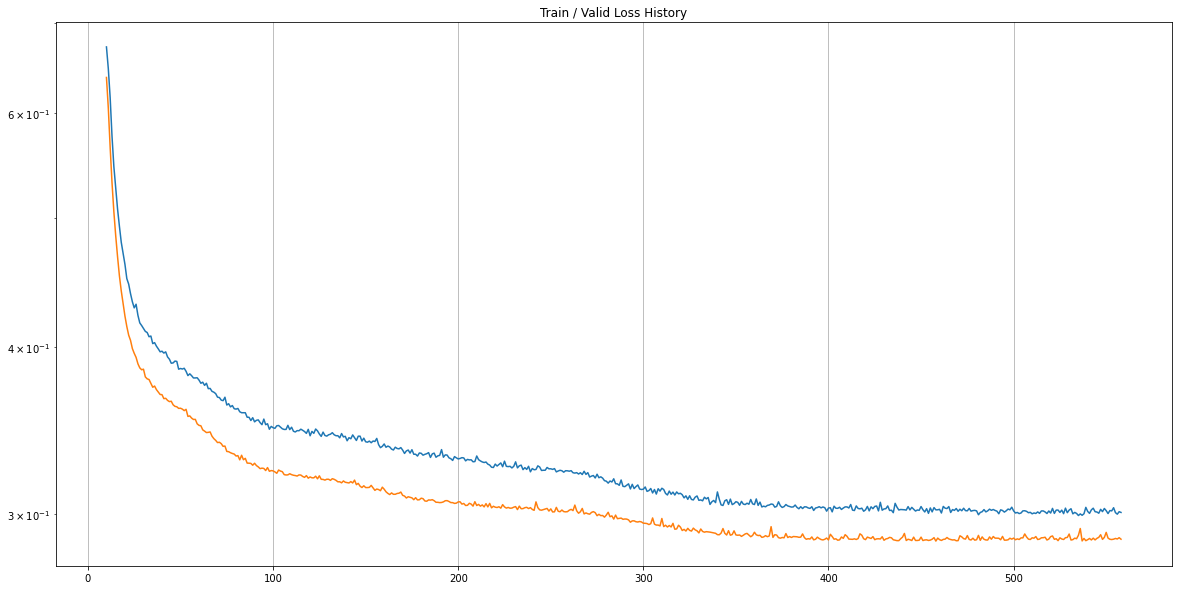

In [ ]:
plot_from = 10

plt.figure(figsize=(20,10)) #인치의 크기를 튜플로 전달해서 그래프 크기를 결정
plt.grid(True) # 그래프의 열을 격자로 나눠준다.
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log') # 로그로 눈금을 그려줌
plt.show()

In [ ]:
test_loss = 0
y_hat = []

with torch.no_grad():
  x_ = x[2].split(batch_size, dim=0)
  y_ = y[2].split(batch_size, dim=0)

  # for epoch: test_set / batch_size
  for x_i, y_i in zip(x_,y_):
    y_hat_i = model(x_i)
    loss = F.mse_loss(y_hat_i, y_i)

    test_loss += loss
    y_hat += [y_hat_i]
test_loss /= len(x_)
y_hat = torch.cat(y_hat, dim=0)

#딕셔너리 형태로 묶어서 정렬한다.
#lamda : 이름없는 함수
sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

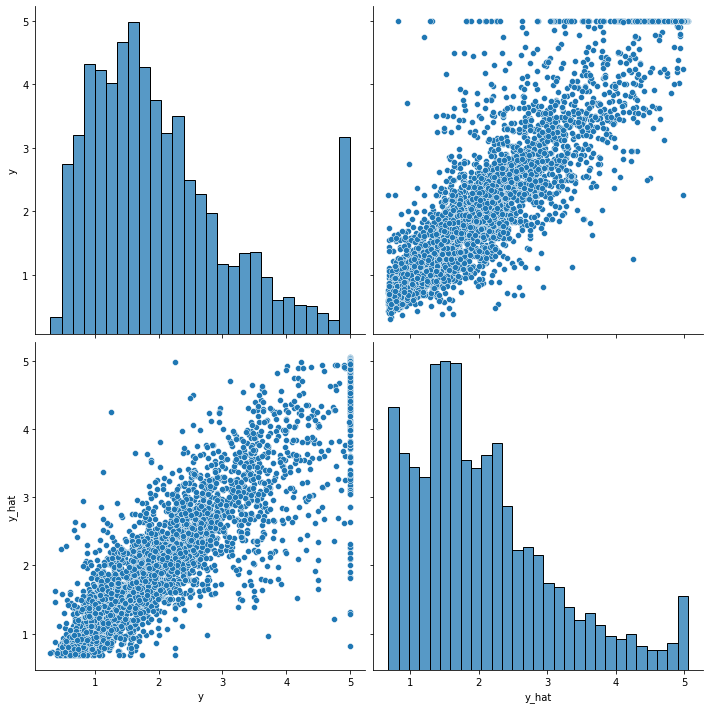

In [ ]:
df = pd.DataFrame(torch.cat([y[2],y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])

sns.pairplot(df, height=5)
plt.show()